# Parsing CityGML files

The main source of building height information is 3D models stored in the CityGML format. CityGML is an open data model and XML-based format for the storage and exchange of virtual 3D city models, see https://www.ogc.org/standards/citygml. It contains precise 3D information, which is beyond what we need in this project. 

This notebook gives an example of how we parse CityGML files and retrieve tabular data files with building id, footprint geometry, a height value and ancillary info.


## XML structures

A comprehensive tutorial on XML processing with *lxml* is provided by https://lxml.de/tutorial.html. Furthermore, https://docs.python.org/2/library/xml.etree.elementtree.html provides an in-depth introduction into the functionalities of the *xml* library, some of which also play an important role in the *lxml* library.  A description of commonly used XPath syntax is given by https://www.w3schools.com/xml/xpath_syntax.asp. Find appropriate paths for a CityGML (XML) file by loading and parsing the file via http://xpather.com/. 

Some parts and explanations of the following example are directly taken from the XML tutorials.

### The basics 

**The element class** (intuitive explanation: the object, e.g. the Building object): An Element is the main container object for the ElementTree API. Most of the XML tree functionality is accessed through this class. Elements are organised in an XML tree structure. Elements are lists: To make the access to these subelements easy and straight forward, elements mimic the behaviour of normal Python lists as closely as possible.

**XML tag** (intuitive explanation: the name of the object or how do we call a specific object type, e.g. `bldg:Building`): The XML tag name of elements is accessed through the tag property (.tag).

**Elements carry attributes as a dict** (intuitive explanation: the attribute(s) of the object, e.g. id): XML elements support attributes. Attributes are just unordered name-value pairs, so a very convenient way of dealing with them is through the dictionary-like interface of Elements. 

**Elements contain text (intuitive explanation: the values of interest, e.g. height and ground surface)**: Elements can contain text: In many XML documents (data-centric documents), this is the only place where text can be found. It is encapsulated by a leaf tag at the very bottom of the tree hierarchy. The text might be accessed through the text property (.text).

**Namespaces**: If the XML input has namespaces, tags and attributes with prefixes in the form prefix:sometag (e.g. `bldg:Building`) get expanded to {uri}sometag (e.g. {http://www.opengis.net/citygml/building/2.0}Building) where the prefix is replaced by the full URI. Also, if there is a default namespace, that full URI gets prepended to all of the non-prefixed tags. One way to search and explore such a XML file is to manually add the URI to every tag or attribute in the xpath of a `.find()` or `.findall()`. A better way to search the namespaced XML example is to create a dictionary with your own prefixes and use those in the search functions.


## Inspect a file

First, open the file `sample-data/1-preprocessing/parsing-citygml/sample_berlin.gml` in a text editor, for example [Sublime](https://www.sublimetext.com/). 

You will see a deep and slightly frightening nested structure, which contains a bunch of information. The structure is essentially nested _elements_ enclosed by a start tag (`<bla>`) and end tag (`</bla>`).

### Elements of interest

The highest level element is **a building**. Note that we can find its id here.

```
<cityObjectMember>
 <bldg:Building gml:id="BLDG_0003000a000b75b4">
     ...
 </bldg:Building>
</cityObjectMember> 
```     

The building has further elements of interest inside of it, for example, the envelope. Within the `gml:Envelope` element, we also find the coordinate reference system and the **bounding box** with spatial coordinates.

```             
        <gml:boundedBy>
           <gml:Envelope srsName="urn:ogc:def:crs:EPSG::25833" srsDimension="3">
               <gml:lowerCorner>388734.413347128 5815869.8811345 42.93</gml:lowerCorner>
               <gml:upperCorner>388747.696594813 5815887.73124282 65.9400002288818</gml:upperCorner>
           </gml:Envelope>
        </gml:boundedBy>             
```

Then comes what we are interested in: the **height** of the building!
```         
        <bldg:measuredHeight>23.01</bldg:measuredHeight>  
```

Finally, we have ground, walls, and roof polygons. Here, we want only the **ground polygon**, so we will want to extract the polygon that is encoded here.
```
        <bldg:boundedBy>
        <bldg:GroundSurface gml:id="UUID_3df05210-0318-44d5-8395-2cd6dd785264">
          <creationDate>2014-07-09</creationDate>
          <bldg:lod2MultiSurface>
            <gml:MultiSurface gml:id="UUID_e7d4c8cb-c08d-4886-948a-1eaed3fa9b96">
              <gml:surfaceMember>
                <gml:Polygon gml:id="GEOM_7095965">
                  <gml:exterior>
                    <gml:LinearRing gml:id="GEOM_7095965_0_">
                      <gml:posList srsDimension="3">388737.260516096 5815887.65605233 42.93 388745.404949586 5815887.40660486 42.93 388747.693293793 5815887.33651752 42.93 388747.147272335 5815869.88520581 42.93 388744.858928122 5815869.95529306 42.93 388736.714494611 5815870.20474021 42.93 388734.416157563 5815870.27513351 42.93 388734.962179054 5815887.72644572 42.93 388737.260516096 5815887.65605233 42.93</gml:posList>
                      </gml:LinearRing>
                    </gml:exterior>
                  </gml:Polygon>
                </gml:surfaceMember>
              </gml:MultiSurface>
            </bldg:lod2MultiSurface>
          </bldg:GroundSurface>
        </bldg:boundedBy>     
```

## Parsing the file with our Python functions

We will load a sample CityGML file for Berlin, parse it and save it.

In [1]:
# import libraries
import numpy as np 
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from lxml import etree
import os, sys

In [2]:
# set the path to the root directory of the git
path_root = r'C:\Users\miln\tubCloud\Work-in-progress\main-project\new_git'

# enable python to find the modules
sys.path.append(path_root)

In [3]:
# import own functions
from utils.preproc_utils import citygml_to_df

In [4]:
# set parameters
crs = 'epsg:25833'

Let's load the CityGML file.

In [5]:
# set path to sample data
path_sample = os.path.join(path_root,'sample-data','1-preprocessing',
                    '1-parsing-citygml','sample_berlin.gml')

# load citygml file
citygml_sample = etree.parse(path_sample)

We will need two pieces of information to parse the file: the root element (the first element of the hierarchy of elements) and a list of building elements.

In [6]:
# get the root element
citygml_root = citygml_sample.getroot()

# extract a list of all building elements
buildings = citygml_sample.findall(".//{"+citygml_root.nsmap['bldg']+"}Building")

Buildings are a list of `bldg:Building` elements. So they contain stuff like:
```
<cityObjectMember>
 <bldg:Building gml:id="BLDG_0003000a000b75b4">
     ...
     <gml:boundedBy>
           <gml:Envelope srsName="urn:ogc:def:crs:EPSG::25833" srsDimension="3">
           ...
           </gml:Envelope>
     </gml:boundedBy>
     ...
     <bldg:measuredHeight>23.01</bldg:measuredHeight>  
     ...
     <bldg:boundedBy>
        <bldg:GroundSurface gml:id="UUID_3df05210-0318-44d5-8395-2cd6dd785264">
        </bldg:GroundSurface>
      </bldg:boundedBy>
      ... 
 </bldg:Building>
</cityObjectMember> 
```
We will have the information available to parse buildings one by one.

In [7]:
buildings[0:5]

[<Element {http://www.opengis.net/citygml/building/2.0}Building at 0x1b5bb2c94c0>,
 <Element {http://www.opengis.net/citygml/building/2.0}Building at 0x1b5bb2c9500>,
 <Element {http://www.opengis.net/citygml/building/2.0}Building at 0x1b5bb2c9540>,
 <Element {http://www.opengis.net/citygml/building/2.0}Building at 0x1b5bb2c9580>,
 <Element {http://www.opengis.net/citygml/building/2.0}Building at 0x1b5bb2c95c0>]

With the function `citygml_to_df`, we will iterate over these buildings to fetch the info we are interested in, and write each building as a new row in a dataframe. 

You need to pass in the function the element list, the root element, a vector of info about the file (country, region, city, district, file name), and the coordinate reference system to use. 

Additionally, sometimes the measured height is not available for some buildings. There is an option to set the parameter `bbox` to True to compute the height based on the lowest and highest point of the bounding box.

In [8]:
df = citygml_to_df(buildings,
                   citygml_root,
                   ['Germany', 'Berlin', 'Berlin', np.nan, 'sample-berlin'],
                   crs,
                   bbox = True
                  )

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.10it/s]


Tada! We have have a nice dataframe with what we want, and only that. 

In [9]:
df.head()

id  height_measured  height_bbox  country  region  \
0  BLDG_0003000a000b75b4         23.01000    23.010000  Germany  Berlin   
1  BLDG_000300000011e629         22.94411    22.944113  Germany  Berlin   
2  BLDG_0003000a000b75b7         22.24238    22.242381  Germany  Berlin   
3  BLDG_000300000010566d         21.27000    21.270000  Germany  Berlin   
4  BLDG_0003000e0046a972         21.59204    21.592045  Germany  Berlin   

     city  district    source file  \
0  Berlin       NaN  sample-berlin   
1  Berlin       NaN  sample-berlin   
2  Berlin       NaN  sample-berlin   
3  Berlin       NaN  sample-berlin   
4  Berlin       NaN  sample-berlin   

                                            geometry  
0  POLYGON ((388737.260516096 5815887.65605233, 3...  
1  POLYGON ((388704.373746487 5815899.16297135, 3...  
2  POLYGON ((388819.773733918 5815875.82850829, 3...  
3  POLYGON ((388665.4457948602 5815730.161206018,...  
4  POLYGON ((388627.453457962 5815942.5572169, 38...

## Running some diagnostics

Once we got our cleaned data, we want to make sure the output is what we want, and also get a first idea of the specificities of the new area.

First, let's check if we are missing some heights and footprint polygons.

In [10]:
print(df['height_bbox'].isnull().sum())
print(df['height_measured'].isnull().sum())
print(df['geometry'].isnull().sum())

0
1
0


We can plot the heights and see if they make sense.

(array([15.,  3.,  4.,  4.,  2.,  7., 17., 90., 12.,  2.]),
 array([ 2.13346 ,  4.789114,  7.444768, 10.100422, 12.756076, 15.41173 ,
        18.067384, 20.723038, 23.378692, 26.034346, 28.69    ]),
 <BarContainer object of 10 artists>)

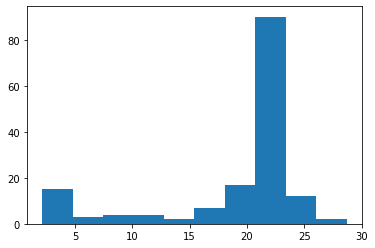

In [11]:
plt.hist(df['height_measured'])

If we have computed the bbox height, we can check if there are differences with the 'measured height'.

In [12]:
diff = df['height_measured'] - df['height_bbox']
print(np.mean(diff))
print(sum(diff > 2))
print(sum(diff < -2))

-0.07843396029141284
0
2


When everything looks fine, we can save the data into a .csv file.

In [ ]:
# drop buildings with missing polygon
df.dropna(subset = ['geometry'], inplace=True)

# save the file
df.to_csv(os.path.join(path_to_data,'Data','Data samples',
                    '1.1-parse_citygml','sample_berlin.csv'),
         index=False)

We have written the geometry into a WKT string, so that we save the data into a CSV file. To be able to visualize the data, we need to load the string into a Shapely polygon, so that Python sees it as a geospatial object and not a string. We then need a GeoDataFrame to manipule (e.g. plot) easily the geospatial data.

In [14]:
# Load WKT string into to Shapely Polygon object
df.geometry = df.geometry.apply(wkt.loads)

# Turn DataFrame into GeoDataFrame
df = gpd.GeoDataFrame(df,geometry='geometry')

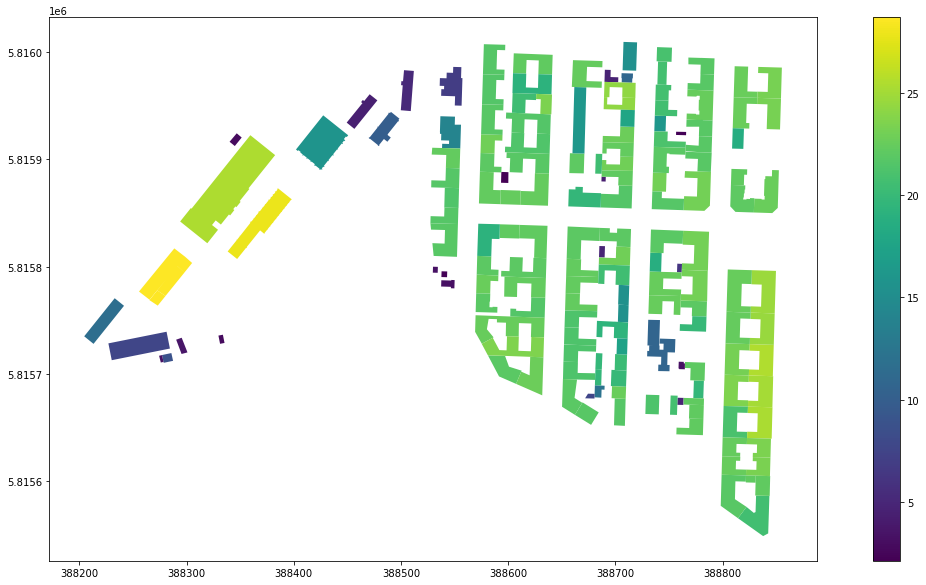

In [15]:
# Plot the result
fig, ax = plt.subplots(figsize=(20,10))
df.plot(column='height_measured',ax=ax,legend=True)
plt.show()

## Start with your own file


The next step after playing around with this example is to take a new file and to process it. An area can come sometimes as either as a bunch of small files, or sometimes as a huge files. You may need then either to loop through the many small files, or to run the `citygml_to_df` function on parts online of the data. 


### Make sure the elements are properly named

CityGML is a standard, and therefore most files should be encoded with the same element names. However, sometimes it is not the case. Therefore, for new files, before running the script you should inspect first if the needed elements in the function are presents in the file. These are:

- **Id:** ``gml:id``
- **Measured height:** `.//bldg:measuredHeight`
- **Ground surface polygon:** `.//bldg:GroundSurface//gml:posList`
- **Bounding box lower corner:** `./gml:boundedBy/gml:Envelope/gml:lowerCorner` 
- **Bounding box upper corner:** `./gml:boundedBy/gml:Envelope/gml:upperCorner`